# Matrix Factorization

## El problema de la Recomendación

Matemáticamente podemos expresar este problema como que queremos estimar "los elementos faltantes" de la matriz de ratings para $n$ usuarios y $m$ items $R \in \mathbb{R}^{n \times m}$.

Si consideramos a $\mathcal{O}$ como el conjunto de los $(i,j)$ para los cuales sí se conoce el verdadero valor, estamos en un escenario en el que
$$
\#(\mathcal{O}) << n \cdot m
$$

es decir, se conocen **tan pocos elementos** que no es factible "completar" la matriz utilizando métodos de *imputation* comunes.

## El modelo de Matrix Factorization (["Funk-SVD"](https://sifter.org/~simon/journal/20061211.html))

Una forma de controlar la dimensionalidad y al mismo tiempo poder realizar predicciones es plantear un modelo de $k$ dimensiones donde se definen $U \in \mathbb{R}^{n \times k}$ la matriz de *features de usuarios* y $V \in \mathbb{R}^{k \times m}$ la matriz de *features de items*, y luego se plantea que
$$
R \approx U \cdot V
$$

De esta manera no sólo se tiene un gran control sobre la dimensionalidad del modelo (vía $k$) sino que además es muy compacto y también permite predecir de forma muy fácil para un usuario y/o para un item.

*Nota: en rigor la matriz utilizada es $U^T$ para que cada vector de usuarios respete la convención de vector columna, pero por claridad y eficiencia se prefiere trabajar con la matriz traspuesta directamente. De la misma manera, $u_i$ considerará la fila $i$ de $U$ mientras que $v_j$ considerará la columna $j$ de $V$.*

### La función objetivo

Como todo modelo, para poder ajustarse a los datos se precisa una función objetivo a maximizar (o de pérdida a minimizar). En este caso se define la pérdida:

$$
J(U, V) = \sum_{(i,j) \in \mathcal{O}} (r_{i,j} - u_i \cdot v_j)^2 + \lambda (||U||^2_2 + ||V||^2_2)
$$

que no es otra cosa que la suma de los errores cuadráticos (RSS) más una regularización por norma $\ell_2$ de ambas matrices para prevenir overfitting.

### ¿Cómo ajustar?

Como es una función **no convexa** no podemos optimizar en forma directa sino que debemos recurrir a otros mecanismos aproximados.

#### Opción 1: SGD (Stochastic Gradient Descent)

El método de optimización sin restricciones por excelencia, en forma iterativa realiza el siguiente ciclo:

1. Selecciona un rating observado $r_{i,j} / (i,j) \in \mathcal{O}$ al azar.
2. Computa las derivadas $\frac{dJ}{du_i},\frac{dJ}{dv_j}$ de la pérdida $J$ respecto de $u_i$, $v_j$, evaluadas en los valores actuales.
3. Realiza un paso de actualización $u_i^{t+1} = u_i^t - \gamma \cdot \frac{dJ}{du_i}(u_i^t)$, $v_j^{t+1} = v_j^t - \gamma \cdot \frac{dJ}{du_i}(v_j^t)$.

Esto se realiza hasta un criterio de convergencia y para un *learning rate* $\gamma > 0$.

#### Opción 2: ALS (Alternating Least Squares)

Este método se utiliza para optimizar objetivos de la forma $R = U \cdot V$, y lo que se hace es iterativamente:

1. Fijamos V, estimamos U por cuadrados mínimos para la ecuación $R = \mathbf{U} \cdot V$
2. Fijamos U, estimamos V por cuadrados mínimos para la ecuación $R = U \cdot \mathbf{V}$

Esto también se hace hasta un criterio de convergencia, que por ejemplo puede ser hasta que la norma de la diferencia en la actualización sea menor a una constante prefijada.

## Un ejemplo de $R$

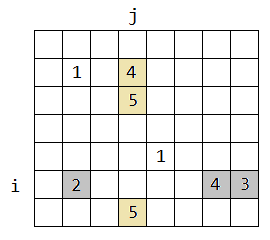

En la imagen, si consideramos índices que inician en 0
* $\mathcal{O} = \{(1,1), (1,3), (2,3), (4,4), (5,1), (5,6), (5,7), (6,3)\}$
* $\mathcal{O}_{i=5} = \{1,6,7\}$
* $\mathcal{O}_{j=3} = \{1,2,6\}$

## Resolviendo la pérdida por cuadrados mínimos para $U$

Esto hay que hacerlo sí o sí por cada fila, dado que no se puede trabajar con la matriz completa $R$ ya que no es conocida. Planteemos el objetivo para un vector fila $u = u_i$:

$$
J(u) = \sum_{j \in \mathcal{O}_i} (r_{i,j} - u \cdot v_j)^2 + \lambda ||u||^2
$$


donde $\mathcal{O}_i = \{j \; / (i,j) \in \mathcal{O}\}$, es decir los índices $j$ tal que, para un $i$ fijo, $(i,j) \in \mathcal{O}$.

La derivada resulta:

$$
\frac{dJ}{du} = -2 \sum_{j \in \mathcal{O}_i} (r_{i,j} - u \cdot v_j) \cdot v_j^T + 2 \lambda u
$$


*Nota: recordar que $||u||^2 = u^T \cdot u$*.

Ahora igualamos a 0 la derivada y despejamos $u$:

$$
-2 \sum_{j \in \mathcal{O}_i} (r_{i,j} - u \cdot v_j) \cdot v_j^T + 2 \lambda u = 0
$$

$$
-2 \sum_{j \in \mathcal{O}_i} r_{i,j} \cdot v_j^T + 2 \sum_{j \in \mathcal{O}_i} u \cdot v_j \cdot v_j^T   + 2 \lambda u = 0
$$

$$
u \cdot (\sum_{j \in \mathcal{O}_i} v_j \cdot v_j^T + \lambda I_k) = \sum_{j \in \mathcal{O}_i} r_{i,j} \cdot v_j^T
$$

$$
u^* =(\sum_{j \in \mathcal{O}_i} r_{i,j} \cdot v_j^T)  \cdot (\sum_{j \in \mathcal{O}_i} v_j \cdot v_j^T + \lambda I_k)^{-1}
$$

*Nota: observar que el anteúltimo renglón es una versión traspuesta del típico $A \cdot x = b$, que es $x^T \cdot A^T = b^T$.*

## Ahora para $V$

Utilizando una notación similar donde $\mathcal{O}_j = \{i \; / (i,j) \in \mathcal{O}\}$, la pérdida respecto de $v$ es:

$$
J(v) = \sum_{i \in \mathcal{O}_j} (r_{i,j} - u_i \cdot v)^2 + \lambda ||v||^2
$$

Derivando respecto de $v$:

$$
\frac{dJ}{dv} = -2 \sum_{i \in \mathcal{O}_j} u_i^T \cdot (r_{i,j} - u_i \cdot v) + 2 \lambda v
$$

Igualamos a 0 y despejamos igual que antes:

$$
(\sum_{i \in \mathcal{O}_j} u_i^T \cdot u_i + \lambda I_k) \cdot v = \sum_{i \in \mathcal{O}_j}  u_i^T \cdot r_{i,j}
$$

$$
v^* = (\sum_{i \in \mathcal{O}_j} u_i^T \cdot u_i + \lambda I_k)^{-1} \cdot (\sum_{i \in \mathcal{O}_j}  u_i^T \cdot r_{i,j})
$$

## Código

* El recomendador va a ser una clase
  * Las matrices se tienen que poder observar como atributos
* El criterio de convergencia va a llevar una función del tipo `f(U_old, V_old, U_new, V_new) -> Bool`
* **NO** se va a hacer énfasis en la performance aunque la optimización sea completamente paralelizable, porque vuelve más difícil de leer el código (y Colab igual presta 1 solo core, así que...)
* Se va a asumir que R es un dataframe con las columnas *user*, *item* y *rating*, donde *user* e *item* representan IDs que van desde 0 hasta n-1 y m-1 respectivamente.


In [1]:
# imports
import numpy as np
import pandas as pd
from collections import defaultdict
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# MF class v2
def ALS(U,V,R, O_is, O_js, lda, debug=True):
  n, k = U.shape
  k_, m = V.shape
  assert k==k_, "k doesn't match between U and V"

  # U pass
  if debug:
    print(f"Solving for U")
  for i in range(n):
    o_i = O_is[i]
    r_v = np.zeros(shape=(1,k))
    v_v_t = np.zeros(shape=(k, k))
    for j in o_i:
      v_j = V[:,j].reshape(-1,1)

      # r_ij * v_j.T
      r_v += R[(i,j)] * v_j.T

      # v_j @ v_j.T
      v_v_t += v_j @ v_j.T

    U[i,:] = r_v @ inv(v_v_t + lda * np.identity(k))

  # V pass
  if debug:
    print(f"Solving for V")
  for j in range(m):
    o_j = O_js[j]
    r_u = np.zeros(shape=(k,1))
    u_t_u = np.zeros(shape=(k, k))
    for i in o_j:
      u_i = U[i,:].reshape(1,-1)

      # u_T * r_ij
      r_u += u_i.T * R[(i,j)]

      # u_T @ u
      u_t_u += u_i.T @ u_i

    # NumPy gets angry when we try to assign column vectors, so we need to flatten
    V[:,j] = (
        inv(u_t_u + lda * np.identity(k)) @ r_u
              ).flatten()

class MFModel:
  def __init__(self, k, lda):
    assert type(k)==int, k > 0
    assert lda > 0
    self.k = k
    self.lda = lda

  def fit(self, R_train, R_valid, rng_seed, iters, debug=True):
    assert iters >= 2, "Min iters can't be 1"
    # seed the rng
    self.rng = np.random.default_rng(rng_seed)

    # reset the historics
    self.valid_mse_historic = []
    self.train_loss_historic = []

    # build some dicts for easier indexing
    self._init_params(R_train)


    # now run at most max_iters iterations of ALS
    for i in range(iters):
      if debug:
        print(f"Running iteration {i+1}/{iters}")

      ALS(self.U, self.V, self.R,
          self.items_by_user, self.users_by_item,
          self.lda, debug)

      self.valid_mse_historic.append(self._estimate_MSE(R_valid, debug=debug))
      self.train_loss_historic.append(self._loss(R_train, debug=debug))

    return self

  def _estimate_RSS(self, R, debug=True):
    """Estimate Residual Sum of Squares (RSS)"""
    rss = 0.0
    for user_id, item_id, rating in R.itertuples(index=False, name=None):
      # predict value
      y_hat = self.predict(user_id, item_id)

      # add squared residual to total
      rss += (y_hat - rating)**2
    if debug:
      print(f"Estimated RSS is {rss:.3f}")
    return rss

  def _estimate_MSE(self, R, debug=True):
    # MSE = RSS / n
    rows = R.shape[0]
    mse = self._estimate_RSS(R,debug) / rows
    if debug:
      print(f"Estimated MSE is {mse:.3f}")
    return mse

  def _loss(self, R, debug=True):
    # loss = RSS + lambda * (Frobenius(U)^2+Frobenius(V)^2)
    U_norm_sqr = np.sum(self.U **2)
    V_norm_sqr = np.sum(self.V **2)
    loss = self._estimate_RSS(R,debug) + self.lda * (U_norm_sqr + V_norm_sqr)
    if debug:
      print(f"U squared norm is {U_norm_sqr:.3f}, V squared norm is {V_norm_sqr:.3f}, loss is {loss:.3f}")
    return loss

  def _init_params(self, R):
    # if ids range from 0 to max_id, then max_id+1 is the number of unique elements
    n = R["user"].max() + 1
    m = R["item"].max() + 1

    # build U, V matrices
    self.U = self.rng.uniform(low=0,high=1/np.sqrt(self.k),size=(n,self.k))
    self.V = self.rng.uniform(low=0,high=1/np.sqrt(self.k),size=(self.k,m))

    # build the observed R values dict and dicts for O_i and O_j
    self.R = dict()
    self.items_by_user = defaultdict(lambda : [])
    self.users_by_item = defaultdict(lambda : [])

    # iterate once through the entire ratings
    for user_id, item_id, rating in R.itertuples(index=False, name=None):
      self.R[(user_id, item_id)] = rating
      self.items_by_user[user_id].append(item_id)
      self.users_by_item[item_id].append(user_id)

  def predict(self, user_id, item_id):
    # as simple as computing the inner product
    # no need for reshaping in this case
    return self.U[user_id,:] @ self.V[:, item_id]

  def recommend(self, user_id, top_k=10):
    # as simple as computing the product against the whole item matrix
    # sorting and getting the top-k is just added functionality
    estimated_ratings = self.U[user_id, :] @ self.V
    known_items = self.items_by_user[user_id]

    return [item_idx for item_idx in np.argsort(estimated_ratings)
              if item_idx not in known_items][:-top_k-1:-1]

  def summary(self):
    print("Nº iter\t\tLoss(train)\t\tMSE(valid)")
    for idx, (train, valid) in enumerate(zip(self.train_loss_historic,
                                             self.valid_mse_historic)):
      print(f"   {idx}\t\t{train:.4f}\t\t   {valid:.4f}")

  def plot_metrics(self, log_scale_train=False, log_scale_valid=False):
    fig, ax = plt.subplots(figsize=(10,8))

    values_valid = np.log10(self.valid_mse_historic) if log_scale_valid else self.valid_mse_historic
    values_train = np.log10(self.train_loss_historic) if log_scale_train else self.train_loss_historic

    iters = list(range(1,len(values_valid)+1))
    ax.plot(iters, values_valid, 'o-', color='black', label='valid MSE')
    ax.set_xlabel("Nº iteration")
    ax.set_ylabel("Validation-set MSE", color='black')
    ax.tick_params(axis='y', labelcolor='black')
    ax.set_title("Metrics for fitted model (Loss on train, MSE on validation)")

    ax2 = ax.twinx()
    ax2.set_ylabel("Train-set Loss",color='red')
    ax2.plot(iters, values_train, 'o-', color='red', label='train loss')
    ax2.tick_params(axis='y', labelcolor='red')

    return fig, ax, ax2

# Set de datos

Vamos a utilizar el small dataset de [MovieLens](https://grouplens.org/datasets/movielens/latest/), que tiene 100.000 ratings de 9000 items para 600 usuarios (1 valor conocido cada 54).

Podemos ver más abajo que cada fila representa un par (user, item) con su rating correspondiente, además del timestamp en que se realizó la puntuación pero eso no lo vamos a usar.

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip .
!unzip ml-latest-small.zip

In [11]:
# load data
df = pd.read_csv("./ml-latest-small/ml-latest-small/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


#### Acomodamos y separamos

In [13]:
rng_seed = 6552
test_size = 0.3 # 30% para validacion
df_train, df_valid = train_test_split(df,
                                      test_size=test_size,
                                      random_state=rng_seed)

df_train.apply(lambda p: len(np.unique(p)), axis=0), df_valid.apply(lambda p: len(np.unique(p)), axis=0)

(userId         610
 movieId       8588
 rating          10
 timestamp    61459
 dtype: int64,
 userId         610
 movieId       6063
 rating          10
 timestamp    27991
 dtype: int64)

In [14]:
# are all valid set users represented in the train set?
train_users_set = set(df_train.userId.unique())
len(df_valid[df_valid.userId.apply(lambda x: x in train_users_set)]), len(df_valid)

(30251, 30251)

In [15]:
# great! what about items?
train_items_set = set(df_train.movieId.unique())
len(df_valid[df_valid.movieId.apply(lambda x: x in train_items_set)]), len(df_valid)

(28927, 30251)

In [16]:
# dropping all "new" items since we couldn't train against them
df_valid = df_valid[df_valid.movieId.apply(lambda x: x in train_items_set)]
len(df_valid)

28927

In [17]:
# are Ids complete? if so we can just do a linear mapping
len(df_train["userId"].unique()) == df_train["userId"].max() , \
  len(df_train["movieId"].unique()) == df_train["movieId"].max()

(True, False)

In [18]:
# preprocess it so ids range from 0 to n-1 and m-1 (users, items respectively)

mapping_items = {item_id: idx for idx, item_id in enumerate(df_train["movieId"].unique())}

R_train = pd.DataFrame({
    "user": df_train["userId"] - 1,
    "item": [mapping_items[item_id] for item_id in df_train["movieId"]],
    "rating": df_train["rating"]
})

R_valid = pd.DataFrame({
    "user": df_valid["userId"] - 1,
    "item": [mapping_items[item_id] for item_id in df_valid["movieId"]],
    "rating": df_valid["rating"]
})

R_train.head()

,user,item,rating
62088,410,0,2.0
27677,186,1,2.0
38113,259,2,5.0
29950,205,3,5.0
24609,169,4,2.0


In [19]:
len(R_train["user"].unique()) == R_train["user"].max()+1, \
  len(R_train["item"].unique()) == R_train["item"].max()+1

(True, True)

In [20]:
# init the MF model
model = MFModel(
    k = 6,
    lda = 8
)

# fit the model on train, validate on valid
model.fit(
    R_train = R_train,
    R_valid = R_valid,
    rng_seed = rng_seed,
    iters = 9,
    debug = True
)

Running iteration 1/9
Solving for U
Solving for V
Estimated RSS is 35201.169
Estimated MSE is 1.217
Estimated RSS is 67876.492
U squared norm is 12635.977, V squared norm is 2562.680, loss is 189465.742
Running iteration 2/9
Solving for U
Solving for V
Estimated RSS is 30495.152
Estimated MSE is 1.054
Estimated RSS is 49278.003
U squared norm is 10847.949, V squared norm is 3381.520, loss is 163113.755
Running iteration 3/9
Solving for U
Solving for V
Estimated RSS is 29207.807
Estimated MSE is 1.010
Estimated RSS is 43069.452
U squared norm is 8726.455, V squared norm is 4007.025, loss is 144937.288
Running iteration 4/9
Solving for U
Solving for V
Estimated RSS is 29360.649
Estimated MSE is 1.015
Estimated RSS is 41701.260
U squared norm is 7443.006, V squared norm is 4476.421, loss is 137056.676
Running iteration 5/9
Solving for U
Solving for V
Estimated RSS is 29713.566
Estimated MSE is 1.027
Estimated RSS is 41408.727
U squared norm is 6738.194, V squared norm is 4805.767, loss is

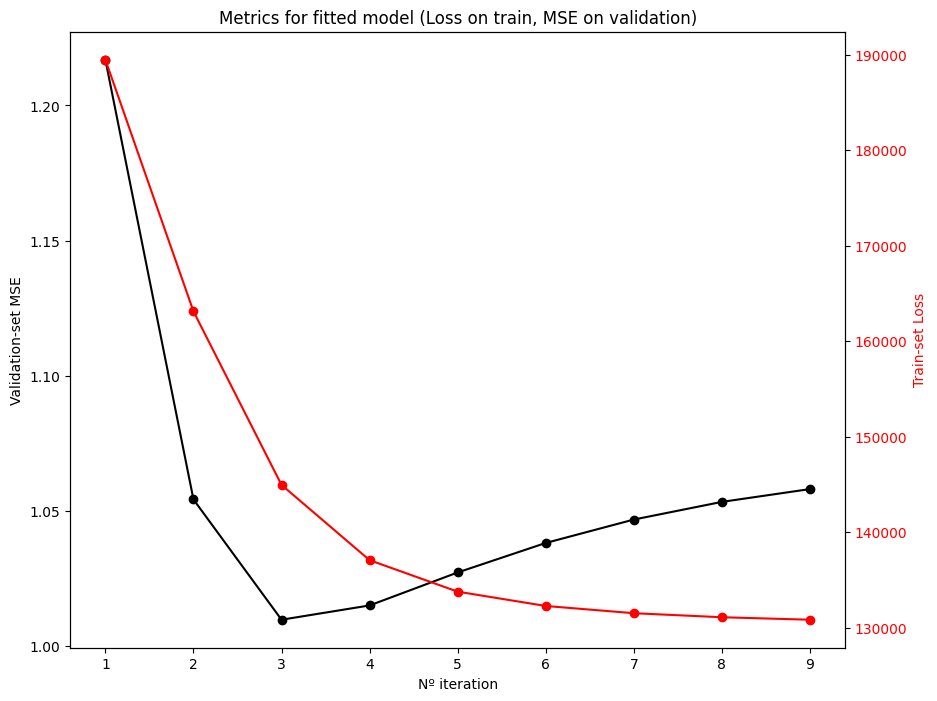

In [21]:
model.plot_metrics()
plt.show()

#### Model overfitting
In iteration 4 the validation MSE increases. The are 3 causes:

- Big value for the k.
- Small value for lambda.
- Too much iterations.

In [22]:
model.summary()

Nº iter		Loss(train)		MSE(valid)
   0		189465.7422		   1.2169
   1		163113.7552		   1.0542
   2		144937.2880		   1.0097
   3		137056.6757		   1.0150
   4		133760.4186		   1.0272
   5		132259.8283		   1.0381
   6		131502.2671		   1.0468
   7		131079.7949		   1.0533
   8		130819.9596		   1.0580


In [36]:
# a smaller model with k=4
model_4 = MFModel(
    k = 4,
    lda = 3
)

model_4.fit(
    R_train = R_train,
    R_valid = R_valid,
    rng_seed = rng_seed+5,
    iters = 6,
)

model_4.summary()

Running iteration 1/6
Solving for U
Solving for V
Estimated RSS is 27119.261
Estimated MSE is 0.938
Estimated RSS is 46064.478
U squared norm is 18594.396, V squared norm is 3057.975, loss is 111021.590
Running iteration 2/6
Solving for U
Solving for V
Estimated RSS is 27875.238
Estimated MSE is 0.964
Estimated RSS is 39320.494
U squared norm is 16607.701, V squared norm is 3519.357, loss is 99701.669
Running iteration 3/6
Solving for U
Solving for V
Estimated RSS is 27793.929
Estimated MSE is 0.961
Estimated RSS is 36896.773
U squared norm is 14976.061, V squared norm is 3807.326, loss is 93246.934
Running iteration 4/6
Solving for U
Solving for V
Estimated RSS is 27094.991
Estimated MSE is 0.937
Estimated RSS is 35236.534
U squared norm is 13528.511, V squared norm is 4086.794, loss is 88082.449
Running iteration 5/6
Solving for U
Solving for V
Estimated RSS is 26440.549
Estimated MSE is 0.914
Estimated RSS is 34027.218
U squared norm is 12236.884, V squared norm is 4375.579, loss is

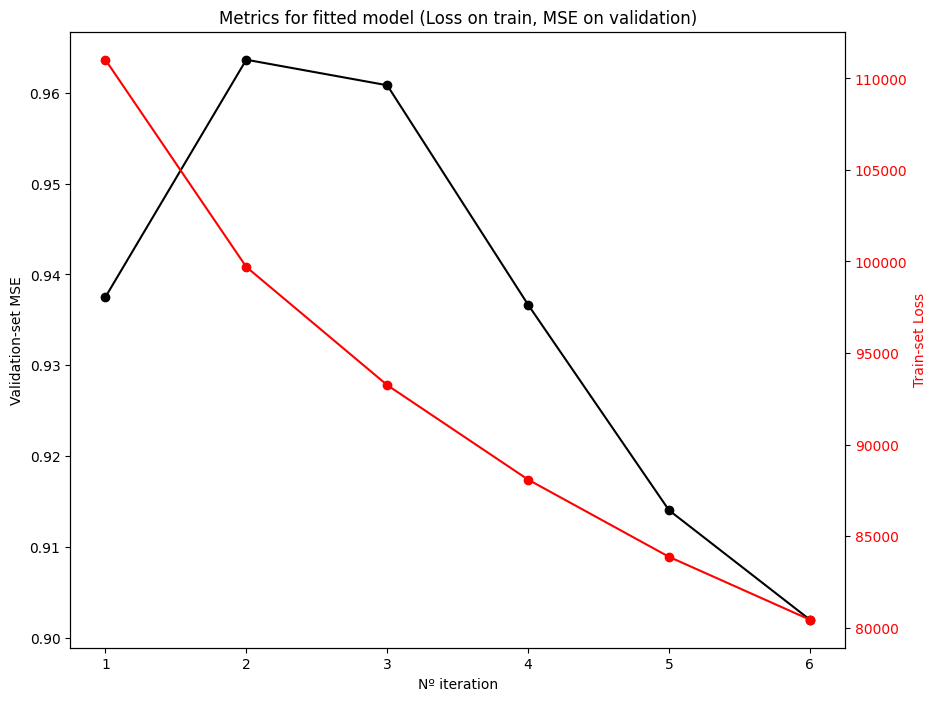

In [37]:
model_4.plot_metrics()
plt.show()

In [40]:
# read movies df
movie_names = pd.read_csv("./ml-latest-small/ml-latest-small/movies.csv")
movie_names.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [67]:
# let's assume we're user 120
some_user_id = 120

recommended_item_id = model_4.recommend(some_user_id, top_k=5)
recommended_item_id

[164, 3239, 3013, 3363, 5249]

In [68]:

movie_names[movie_names['movieId'].isin(recommended_item_id)]

#there are 2 that are not in the dataset??

,movieId,title,genres
137,164,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
2270,3013,Bride of Re-Animator (1990),Comedy|Horror
2515,3363,American Graffiti (1973),Comedy|Drama


In [42]:
# let's see what we loved
most_liked = df_train[df_train.userId == some_user_id+1].sort_values(by="rating",ascending=False).head(10)
most_liked

,userId,movieId,rating,timestamp
18777,121,16,5.0,847656340
18784,121,62,5.0,847656203
18776,121,11,4.0,847656100
18824,121,539,4.0,847656045
18807,121,337,4.0,847656180
18773,121,1,4.0,847656180
18781,121,39,4.0,847656062
18826,121,590,4.0,847655899
18780,121,25,4.0,847656224
18803,121,296,4.0,847655899


In [43]:
# join by movie_name
most_liked.set_index("movieId").join(movie_names.set_index("movieId")).loc[:,["title", "rating", "genres"]]

,title,rating,genres
movieId,,,
16,Casino (1995),5.0,Crime|Drama
62,Mr. Holland's Opus (1995),5.0,Drama
11,"American President, The (1995)",4.0,Comedy|Drama|Romance
539,Sleepless in Seattle (1993),4.0,Comedy|Drama|Romance
337,What's Eating Gilbert Grape (1993),4.0,Drama
1,Toy Story (1995),4.0,Adventure|Animation|Children|Comedy|Fantasy
39,Clueless (1995),4.0,Comedy|Romance
590,Dances with Wolves (1990),4.0,Adventure|Drama|Western
25,Leaving Las Vegas (1995),4.0,Drama|Romance


In [44]:
# get names for our recommendations
movie_names.set_index("movieId").iloc[recommended_item_id]

,title,genres
movieId,,
194,Smoke (1995),Comedy|Drama
4378,Sexy Beast (2000),Crime|Drama
4031,All the Pretty Horses (2000),Drama|Romance|Western
4571,Bill & Ted's Excellent Adventure (1989),Adventure|Comedy|Sci-Fi
8609,Our Hospitality (1923),Comedy


## Otra vuelta de rosca

¿Qué pasa si queremos agregar *features* a medida para los usuarios y las peliculas en vez de simplemente $x=(user\_id, item\_id)$?

Sea nuestro vector de features $x=(x_1, \dots, x_n)$, un modelo lineal con interacciones de orden 2 sería:

$$
y \approx w_0 + \sum_{i=1}^n w_i \cdot x_i + \sum_{i=1}^n\sum_{j=i+1}^n w_{i,j} \cdot x_i \cdot x_j
$$

Pero para un modelo con $n$ *features* para $x$, hay que estimar $1+n+\frac{n(n+1)}{2} = \frac{1}{2}n^2+\frac{3}{2}n+1 = \mathcal{O}(n^2)$, es decir, la cantidad de parámetros escala en forma cuadrática con la cantidad de features. Esto **no** es bueno porque vuelve al modelo mucho más complejo de lo que puede expresar, especialmente en un contexto en el que **las observaciones son escasas**.

### Factorization Machines ([Paper](www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf))

¿Y qué pasa si, al igual que con el rating, expresamos cada peso de la interacción como el producto interno de vectores latentes? Sea $V \in \mathbb{R}^{n \times k}$, ahora el modelo es
$$
y \approx w_0 + \sum_{i=1}^n w_i \cdot x_i + \sum_{i=1}^n\sum_{j=i+1}^n \langle V_{i,:},V_{j,:}\rangle \cdot x_i \cdot x_j
$$

y nuevamente la cantidad de parámetros es $1+n+kn = \mathcal{O}(kn)$ lo cual vuelve a ser lineal respecto de la cantidad de features (y también de $k$!).